# Название проекта: Определение жанра по изображению обложки музыкального диска

**Описание проекта**
<br>Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки

**Цель проекта**
<br>Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки

**Метрики**: `Accuracy`, `Precision`, `Recall`, `F1`

**Данные**
<br>Изображения в формате PNG, упакованные в zip-архивы. 
<br>Имя архива соответствует музыкальному жанру.
<br>Каждый zip-архив содержит папку с изображениями музыкальных обложек соответствующего жанра.

**Дополнительные задачи**
- **Кластеризация**: исследовать, какие жанры лучше выделяются на фоне других, а какие – трудноразделимы.
- **API MusicBrainz**: расширение датасета новыми изображениями. Можно расширить список жанров и использовать обратную сторону обложки.
- **OCR + NLP**: извлечь текст из изображения и обогатить решение применением NLP.
- **Создание рекомендательной системы** в миниатюре, опираясь на изображения.
- **Streamlit**: оформить классификатор жанров или рекомендательную систему в виде веб-приложения.

**Ход исследования**
- Ознакомление с данными;
- Предварительная обработка данных;
- Определение целевой метрики;
- Подготовка данных для baseline-модели;
- Создание baseline-модели;
- Расчет метрик;
- Подготовка данных для нейронной сети;
- Обучение нейронной сети;
- Расчет и сравнение метрик;
- Анализ финальной модели;
- Исследование/решение дополнительных задач;
- Подготовка отчета по исследованию.

Настройка среды

In [1]:
# !pip install pandas
# !pip install seaborn
# !pip install torch
# !pip install faiss-cpu
# !pip install torchvision
# !pip install scikit-learn
# !pip install mlflow
# !pip install psycopg2-binary
# !pip install python-dotenv
# !pip install fastai

In [1]:
import os
import pandas as pd
import seaborn as sns
import psycopg2 as psycopg
import matplotlib.pyplot as plt

from dotenv import load_dotenv

In [2]:
# !pip freeze > requirements.txt
os.environ['VIRTUAL_ENV']

'/home/denis/Documents/main_venv/music_genre_determining/.env_genre'

Установка глобальных переменных

In [3]:
DATA_PATH = 'data'
ASSETS_DIR = 'assets'
RANDOM_STATE = 42
TRACKING_SERVER_PORT = 5000
TRACKING_SERVER_HOST = "127.0.0.1"
EXPERIMENT_NAME = 'music_genres'
RUN_NAME = ['baseline_0_registry', 'svm_rbf_registry']
REGISTRY_MODEL_NAME = ['baseline', 'svm_linear_kernel', 'svm_rbf_kernel']

load_dotenv()
connection = {"sslmode": "require",
              "target_session_attrs": "read-write"}
postgres_credentials = {"host": os.getenv("DB_HOST"),
                        "port": os.getenv("DB_PORT"),
                        "dbname": os.getenv("DB_NAME"),
                        "user": os.getenv("DB_USERNAME"),
                        "password": os.getenv("DB_PASSWORD")}

Импорт класса для проведения исследования

In [4]:
%load_ext autoreload
%autoreload 2

from research_class import DatasetExplorer

Создание экземпляра класса

In [5]:
explorer = DatasetExplorer(DATA_PATH=DATA_PATH, ASSETS_DIR=ASSETS_DIR)

## Знакомство с данными

Количество уникальных жанров: 10

Вывод общей информации:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7800 entries, 0 to 7799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  7800 non-null   object
 1   genre_name  7800 non-null   object
dtypes: object(2)
memory usage: 122.0+ KB

Первые пять строк датафрейма:


,image_name,genre_name
0,8fefae6e-bf75-4b5e-acd6-9ba483009534.png,black metal
1,f7df5071-6f2d-4593-a9b1-34fe8ed971c1.png,black metal
2,1247b021-ad19-42d5-bbe0-b950f75b95c5.png,black metal
3,03b3ed83-3334-4906-a678-7b90e256d363.png,black metal
4,1b966d7f-53cf-42fd-a884-cc86aa1ce7a2.png,black metal


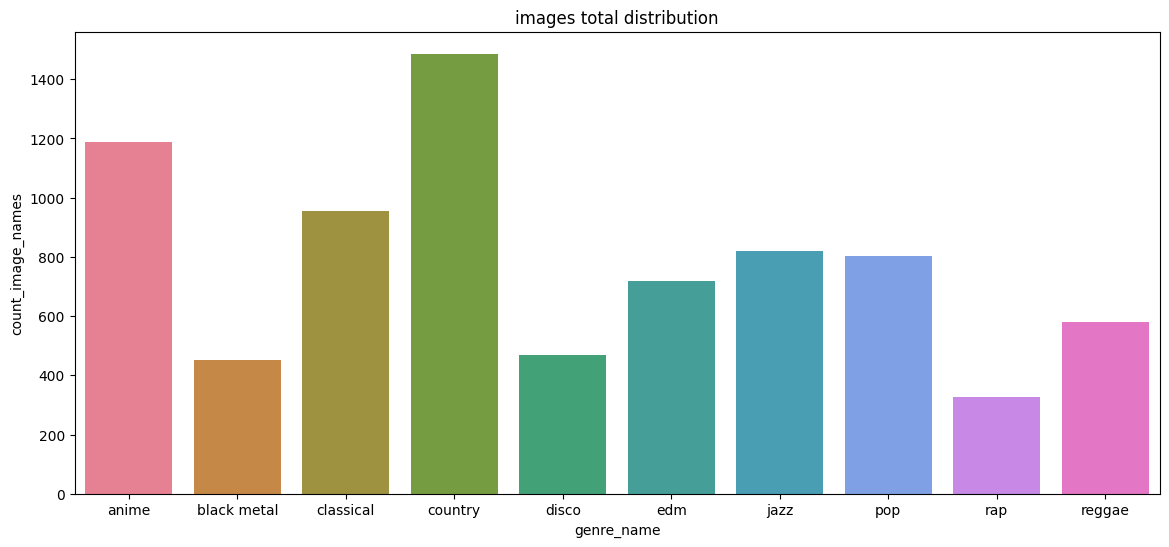

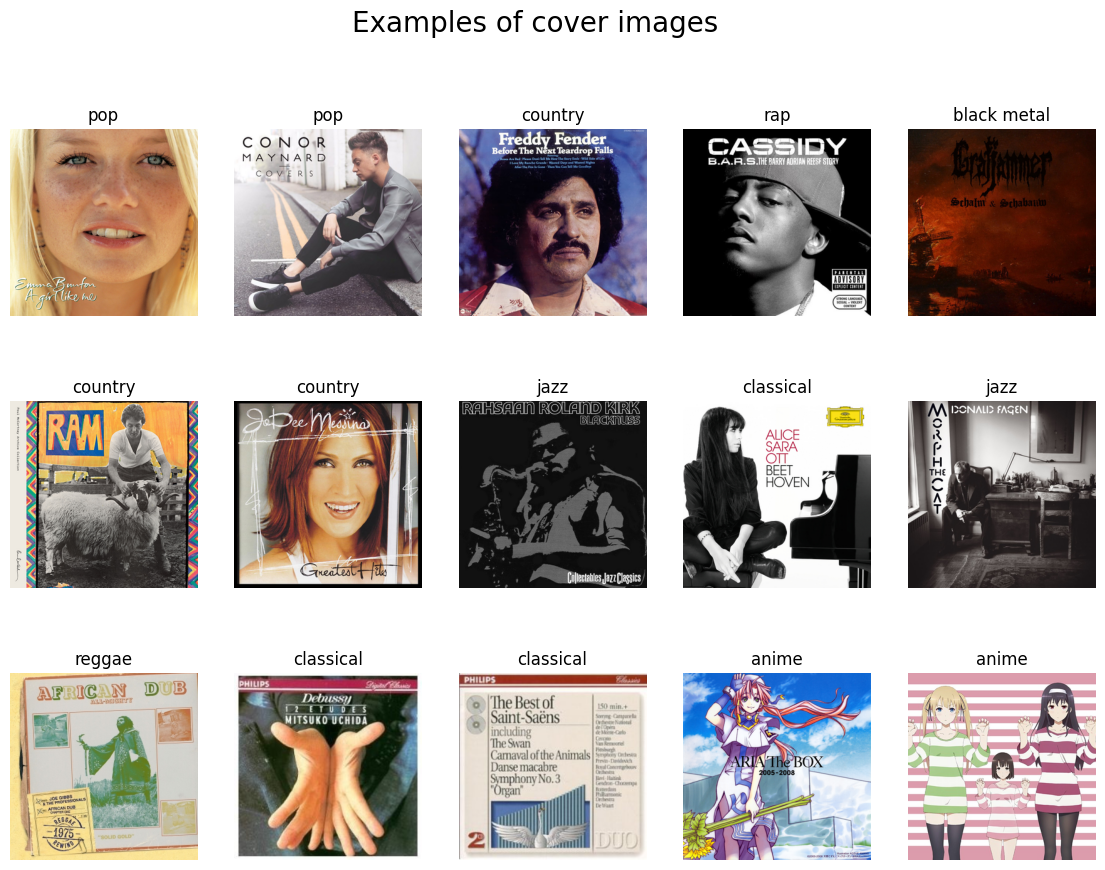

Количество полных повторов строк: 0
Количество повторов названий изображений: 4
Размеры изображений: [(300, 300)]


In [22]:
df = explorer.explore_dataset()

In [12]:
print("Повторяющиеся названия изображений:")
df[df.duplicated(subset=['image_name'], keep=False)]

Повторяющиеся названия изображений:


,image_name,genre_name,image_size
2348,6ea3d2de-f234-4bdd-8ba8-4e9523f5ae1a.png,pop,"(300, 300)"
2371,9123d325-bf8e-4423-be98-98478dccee20.png,pop,"(300, 300)"
2636,7e5955d3-c4f3-493c-a3d4-8b855bfc1833.png,pop,"(300, 300)"
5159,5c4f2c7c-8412-39fa-9468-23c52e285cd7.png,reggae,"(300, 300)"
5396,9123d325-bf8e-4423-be98-98478dccee20.png,rap,"(300, 300)"
5519,7e5955d3-c4f3-493c-a3d4-8b855bfc1833.png,rap,"(300, 300)"
5802,6ea3d2de-f234-4bdd-8ba8-4e9523f5ae1a.png,disco,"(300, 300)"
5948,5c4f2c7c-8412-39fa-9468-23c52e285cd7.png,disco,"(300, 300)"


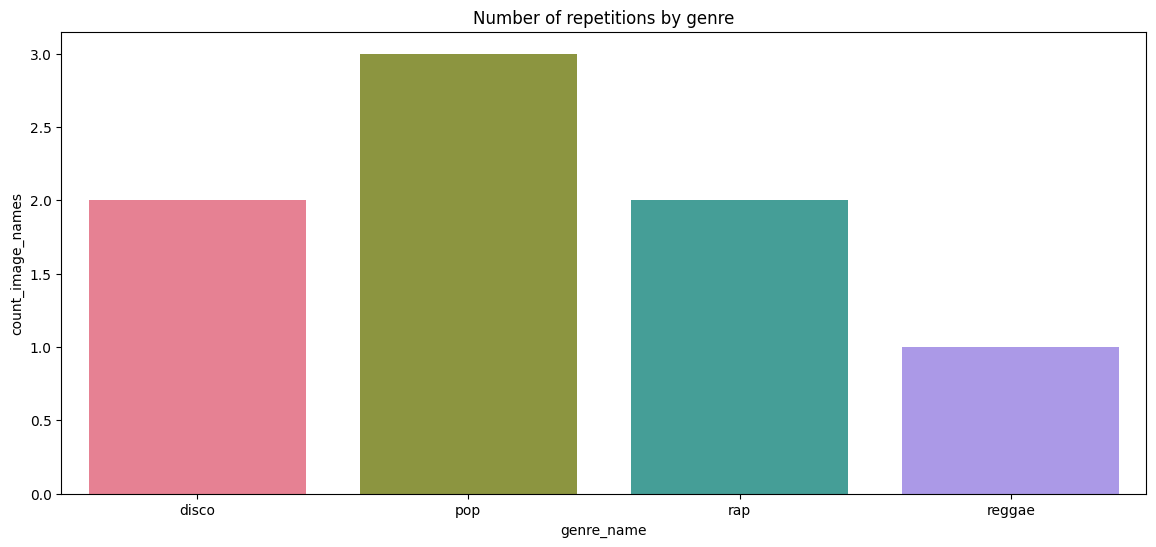

In [13]:
plt.figure(figsize=(14, 6))
df_agg = df[df.duplicated(subset=['image_name'], keep=False)].groupby('genre_name').agg({'image_name': 'count'}).reset_index()
df_agg.rename(columns={'image_name': 'count_image_names'}, inplace=True)
sns.barplot(data=df_agg,
            x='genre_name',
            y='count_image_names',
            hue='genre_name',
            palette=sns.color_palette("husl", len(df_agg)))

plt.title(f"Number of repetitions by genre")

plt.savefig(os.path.join(ASSETS_DIR, 'Number of repetitions by genre.png'))
plt.show()

### Выводы и наблюдения:
- создан датафрейм, состоящий из названий обложек и целевой переменной (название жанра);
- количество представленных изображений - 7800 штук;
- количество уникальных жанров - 10;
- наименьшее количество образцов представлено в жанре `rap`;
- больше всего изображений обложек из жанра `country`;
- судя по образцам изображений, дополнительных манипуляций над ними не требуется;
- полных повторов строк не обнаружено;
- все представленные изображения одного размера - (300, 300);
- обнаружено несколько совпадений названий изображений,
  <br>их точечный анализ показал, что альбомы с этими изображаениями относятся к различным музыкальным жанрам;
- жанр, в котором больше всего пересечений альбомов с другими жанрами - `pop`

## Подготовка базового набора данных

In [6]:
features_array = explorer.data_preprocessing()

Размерность массива с векторами признаков: (7800, 1000)


### Выводы и наблюдения:
- при помощи библиотеки `ResNet18_Weights.IMAGENET1K_V1` получен массив векторов изображений

## Обучение моделей

### Baseline

In [19]:
baseline_metrics, X_train, y_train, X_test, y_test, model = explorer.model_fitting(model_name='Baseline',
                                                                                   features=features_array,
                                                                                   labels=df['genre_name'],
                                                                                   params=None)

Размерности выборок:
обучающая (4680, 1000)
валидационная (1560, 1000)
тестовая (1560, 1000)
Classification Report:
              precision    recall  f1-score   support

       anime       0.62      0.55      0.58       238
 black metal       0.59      0.56      0.57        90
   classical       0.43      0.66      0.52       191
     country       0.39      0.42      0.41       297
       disco       0.24      0.15      0.18        94
         edm       0.45      0.40      0.42       144
        jazz       0.20      0.23      0.21       164
         pop       0.25      0.22      0.23       160
         rap       0.26      0.21      0.23        66
      reggae       0.27      0.20      0.23       116

    accuracy                           0.39      1560
   macro avg       0.37      0.36      0.36      1560
weighted avg       0.39      0.39      0.39      1560



Логирование метрик

In [103]:
metadata = {
    'author': 'denis_zeit',
    'training_date': '2024-04-18',
    'data_used': 'wo_test_data',
    'library_versions': {'mlflow': '2.11.3',
                         'faiss-cpu': '1.8.0',
                         'scikit-learn': '1.4.2',
                         'torch': '2.2.2',
                         'torchvision': '0.17.2'}
}
explorer.model_logging(experiment_name=EXPERIMENT_NAME,
                       run_name=RUN_NAME[0],
                       registry_model=None,
                       params=None,
                       metrics=baseline_metrics,
                       model=None,
                       train_data=X_train,
                       train_label=y_train,
                       metadata=metadata,
                       code_paths=['music_genres.ipynb', 'research_class.py'],
                       tsh=TRACKING_SERVER_HOST,
                       tsp=TRACKING_SERVER_PORT)

2024/04/18 17:47:20 INFO mlflow.tracking.fluent: Experiment with name 'music_genres' does not exist. Creating a new experiment.


### SVM

In [57]:
svm_params = {'kernel': 'rbf',
              'C': 1.0,
              'max_iter': -1,
              'random_state': RANDOM_STATE}
svm_metrics, X_train, y_train, X_test, y_test, model_svm = explorer.model_fitting(model_name='SVM',
                                                                              features=features_array,
                                                                              labels=df['genre_name'],
                                                                              params=svm_params)

Размерности выборок:
обучающая (4680, 1000)
валидационная (1560, 1000)
тестовая (1560, 1000)
Classification Report:
              precision    recall  f1-score   support

       anime       0.67      0.76      0.71       238
 black metal       0.70      0.79      0.74        90
   classical       0.74      0.66      0.70       191
     country       0.47      0.64      0.54       297
       disco       0.53      0.10      0.16        94
         edm       0.56      0.56      0.56       144
        jazz       0.38      0.32      0.35       164
         pop       0.35      0.38      0.36       160
         rap       0.52      0.24      0.33        66
      reggae       0.42      0.41      0.41       116

    accuracy                           0.53      1560
   macro avg       0.53      0.48      0.49      1560
weighted avg       0.54      0.53      0.52      1560



Логирование модели и метрик

In [15]:
metadata = {
    'author': 'denis_zeit',
    'training_date': '2024-04-19',
    'data_used': 'wo_test_data',
    'library_versions': {'mlflow': '2.11.3',
                         'scikit-learn': '1.4.2',
                         'torch': '2.2.2',
                         'torchvision': '0.17.2'}
}

explorer.model_logging(experiment_name=EXPERIMENT_NAME,
                       run_name=RUN_NAME[1],
                       registry_model=REGISTRY_MODEL_NAME[2],
                       params=svm_params,
                       metrics=svm_metrics,
                       model=model,
                       train_data=X_train,
                       train_label=y_train,
                       metadata=metadata,
                       code_paths=['music_genres.ipynb', 'research_class.py'],
                       tsh=TRACKING_SERVER_HOST,
                       tsp=TRACKING_SERVER_PORT)

Successfully registered model 'svm_rbf_kernel'.
2024/04/19 17:20:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: svm_rbf_kernel, version 1
Created version '1' of model 'svm_rbf_kernel'.


### Custom torch_nn

In [18]:
nn_params = {
    'hidden_layers': [[64, 32], [128, 64], [256, 128]],
    'activation': ['relu', 'tanh', 'softmax'],
    'learning_rate': [0.001, 0.01],
    'epochs': [5, 10]
}
nn_metrics, X_train, y_train, X_test, y_test, nn_model = explorer.model_fitting(model_name='NeuralNetwork',
                                                                                features=features_array,
                                                                                labels=df['genre_name'],
                                                                                params=nn_params)

Размерности выборок:
обучающая (4680, 1000)
валидационная (1560, 1000)
тестовая (1560, 1000)
Classification Report:
              precision    recall  f1-score   support

       anime       0.47      0.86      0.61       238
 black metal       0.71      0.74      0.73        90
   classical       0.80      0.56      0.66       191
     country       0.44      0.63      0.52       297
       disco       0.00      0.00      0.00        94
         edm       0.48      0.60      0.54       144
        jazz       0.47      0.21      0.29       164
         pop       1.00      0.01      0.01       160
         rap       0.00      0.00      0.00        66
      reggae       0.30      0.58      0.40       116

    accuracy                           0.48      1560
   macro avg       0.47      0.42      0.37      1560
weighted avg       0.51      0.48      0.42      1560



/home/denis/Documents/main_venv/music_genre_determining/.env_genre/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/denis/Documents/main_venv/music_genre_determining/.env_genre/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/denis/Documents/main_venv/music_genre_determining/.env_genre/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

Логирование модели и метрик

In [20]:
metadata = {
    'author': 'denis_zeit',
    'training_date': '2024-04-19',
    'data_used': 'wo_test_data',
    'library_versions': {'mlflow': '2.11.3',
                         'scikit-learn': '1.4.2',
                         'torch': '2.2.2',
                         'torchvision': '0.17.2'}
}

explorer.model_logging(experiment_name=EXPERIMENT_NAME,
                       run_name='nn_1_gscv_second',
                       registry_model='custom_nn_model',
                       params=nn_model.get_params(),
                       metrics=nn_metrics,
                       model=nn_model,
                       train_data=X_train,
                       test_data=X_test,
                       test_label=y_test,
                       metadata=metadata,
                       code_paths=['music_genres.ipynb', 'research_class.py'],
                       tsh=TRACKING_SERVER_HOST,
                       tsp=TRACKING_SERVER_PORT)

Registered model 'custom_nn_model' already exists. Creating a new version of this model...
2024/04/25 10:38:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: custom_nn_model, version 2
Created version '2' of model 'custom_nn_model'.


### NN fastai_vision

In [19]:
fa_params = {'dl_type': 'from_folder',
             'fit_type': 'fine_tune',
             'arch': 'resnet18',
             'batch': 16,
             'lr': 0.001,
             'epochs': 3}

fa_metrics, X_train, y_train, X_test, y_test, idl, fa_model = explorer.model_fitting(model_name='fastai', params=fa_params)

Первые три элемента загрузчика:


[Path('data/edm/55c478b7-6f5a-44fe-89b7-4fced6798009.png'),
 Path('data/country/956ef697-f5b4-4623-86ee-e2027d27aadc.png'),
 Path('data/black metal/8fefae6e-bf75-4b5e-acd6-9ba483009534.png')]

epoch,train_loss,valid_loss,accuracy,time
0,1.962397,1.459658,0.528846,26:18


epoch,train_loss,valid_loss,accuracy,time
0,1.266009,1.227387,0.591667,25:52
1,0.519446,1.139069,0.641026,25:48
2,0.120816,1.125029,0.652564,25:37


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       218
           1       0.86      0.87      0.86        84
           2       0.87      0.81      0.84       183
           3       0.58      0.79      0.67       295
           4       0.51      0.37      0.43       114
           5       0.69      0.66      0.68       149
           6       0.53      0.49      0.51       169
           7       0.48      0.53      0.50       175
           8       0.62      0.53      0.57        59
           9       0.59      0.54      0.56       114

    accuracy                           0.65      1560
   macro avg       0.66      0.63      0.64      1560
weighted avg       0.66      0.65      0.65      1560



Логирование модели и метрик

In [83]:
metadata = {
    'author': 'denis_zeit',
    'training_date': '2024-04-25',
    'data_used': 'all_data',
    'library_versions': {'mlflow': '2.11.3',
                         'fastai': '2.7.14'}
}

explorer.model_logging(experiment_name=EXPERIMENT_NAME,
                       run_name='fastai_nepochs_10_rn50',
                       registry_model='fastai',
                       params=fa_params,
                       metrics=metrics,
                       model=model_rn50,
                       train_data=X_train,
                       test_data=X_test,
                       test_label=y_test,
                       metadata=metadata,
                       code_paths=['music_genres.ipynb', 'research_class.py'],
                       tsh=TRACKING_SERVER_HOST,
                       tsp=TRACKING_SERVER_PORT)

2024/04/25 18:55:35 INFO mlflow.models.utils: We convert input dictionaries to pandas DataFrames such that each key represents a column, collectively constituting a single row of data. If you would like to save data as multiple rows, please convert your data to a pandas DataFrame before passing to input_example.
2024/04/25 18:55:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Registered model 'fastai' already exists. Creating a new version of this model...
2024/04/25 18:55:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: fastai, version 3
Created version '3' of model 'fastai'.


### Выводы и наблюдения
- за базовую модель принята `faiss`, полученные на ней метрики:
  - `accuracy` - 0.39, `f1` - 0.38;
- обучена модель `SVM`:
  - `accuracy` - 0.53, `f1` - 0.51;
- обучена простая кастомная нейронная сеть:
  - `accuracy` - 0.49, `f1` - 0.49;
- обучена нейронная сеть из библиотеки `fastai`
  - для подготовки данных к обучению нейронной сети использован загрузчик `ImageDataLoaders.from_folder`
  - `accuracy` - 0.67, `f1` - 0.66;
- все модели и метрики залогированы.

## Выбор лучшей модели

In [6]:
connection.update(postgres_credentials)
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        # cur.execute(f"SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
        # table_data = []
        # for table_name in cur.fetchall():
        #     cur.execute(f"SELECT COUNT(*) FROM {table_name[0]}")
        #     table_data.append((table_name[0], cur.fetchone()[0]))
        # print('Находящиеся в базе таблицы:')
        # display(pd.DataFrame(table_data, columns=['table_name', 'number_of_rows']))

        cur.execute("""
                       SELECT
                         COALESCE(model_versions.name, 'baseline') AS model_name,
                         model_versions.version,
                         MAX(CASE WHEN metrics.key = 'precision' THEN metrics.value END) AS precision,
                         MAX(CASE WHEN metrics.key = 'accuracy' THEN metrics.value END) AS accuracy,
                         MAX(CASE WHEN metrics.key = 'recall' THEN metrics.value END) AS recall,
                         MAX(CASE WHEN metrics.key = 'f1' THEN metrics.value END) AS f1,
                         MAX(CASE WHEN metrics.key = 'err1' THEN metrics.value END) AS err1,
                         MAX(CASE WHEN metrics.key = 'err2' THEN metrics.value END) AS err2,
                         metrics.run_uuid
                       FROM metrics
                         LEFT JOIN model_versions ON model_versions.run_id=metrics.run_uuid
                       WHERE metrics.key NOT IN ('fit_time', 'score_time')
                         AND metrics.run_uuid NOT IN ('22d36f7c8a5d43e8968d5f13f83b1b62',
                                                      'ca8a180772d048b5876d941f523a2d85',
                                                      '94467a97c28240e5ac7a2513fee3ea50',
                                                      'c7c0aff05d984e9d9136764e33bad0e3',
                                                      'b3f1598242704e45b0a7ca663d16eca8')
                       GROUP BY COALESCE(model_versions.name, 'baseline'), model_versions.version, metrics.run_uuid
                       ORDER BY accuracy DESC
                       """)
        table_data = cur.fetchall()
        table_columns = [desc[0] for desc in cur.description]
        print('Модели и их метрики:')
        display(pd.DataFrame(table_data, columns=table_columns))

Модели и их метрики:


,model_name,version,precision,accuracy,recall,f1,err1,err2,run_uuid
0,fastai,3.0,0.665358,0.666026,0.666026,0.663648,0.001282,0.000000,8bfe6a55774c49c6bcff1f74c7bd7530
1,fastai,2.0,0.643521,0.644231,0.644231,0.639002,0.001282,0.000000,197269bfe7bf4285bd807e50fa9150e1
2,fastai,1.0,0.542921,0.550000,0.550000,0.535183,0.002564,0.000641,35f22a40196e49df880954f1aa9002ba
3,svm_rbf_kernel,1.0,0.535079,0.533974,0.533974,0.519716,0.001923,0.001923,283ec59ad8294338ba20664b633498dc
4,svm_linear_kernel,1.0,0.489431,0.505128,0.505128,0.493733,0.001923,0.001923,085d7711faaa431a95e8de89252bf8f8
5,custom_nn_model,1.0,0.433017,0.487821,0.487821,0.448810,0.003846,0.001282,623ddd9aeefe4d3cb154fe067f17e9b0
6,custom_nn_model,2.0,0.513411,0.483333,0.483333,0.424643,0.001923,0.005769,e65ea1549b5c4a6aa7dcdbccb6d94d8e
7,baseline,NaN,0.389390,0.392308,0.392308,0.385678,0.003205,0.002564,65cb80ece170449fb5d3b2ff179e52f2


### Выводы и наблюдения
- лучший результат показала модель `fastai` с весами `resnet50`, обученная на 10-ти эпохах

## Анализ финальной модели

Recorder plot sched


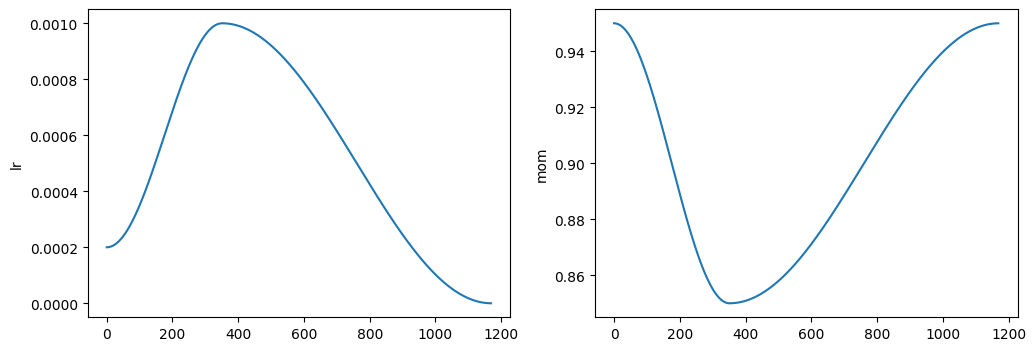

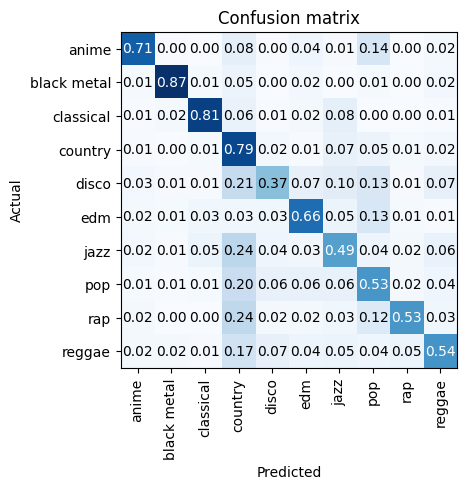

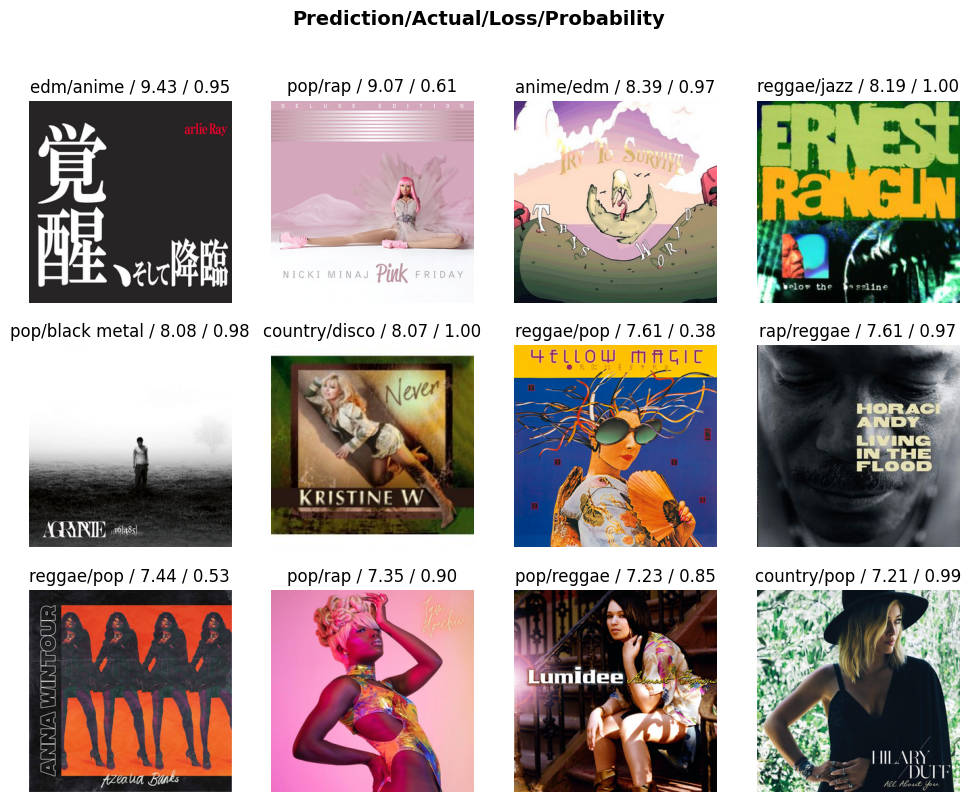

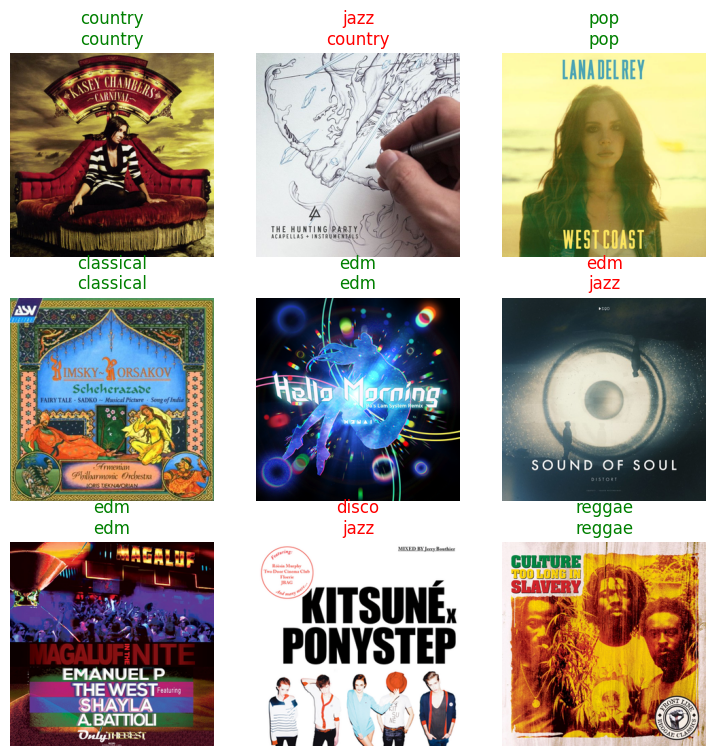

In [28]:
explorer.model_analysis(fa_model)

### Выводы и наблюдения
- матрица ошибок показывает, что наиболее точно определяются жанры:
  <br>`black_metal`, `classical`, `country`;
- хуже всех - `disco`, `jazz`;
- меньше всего некорректных жанров предсказывается для `anime`;
- жанр, чаще других попадающий в некорректные предсказания:
  - label - `disco`, prediction - `country`;
  - label - `jazz`, prediction - `country`;
  - label - `pop`, prediction - `country`;
  - label - `rap`, prediction - `country`;
  - label - `reggae`, prediction - `country`

## Заключение
Отчёт по исследованию

**Ознакомление с данными**
- данные прочитаны,
- выведены несколько образцов изображений с метками;
- проверен баланс классов;
- выявлен факт принадлежности одного изображения к разным жанрам;
- проверен размер изображений;

**Предварительная обработка данных**
- получены эмбеддинги изображений при помощи `ResNet18`;

**Определение целевой метрики**
- целевой метрикой выбрана `accuracy`,
  <br>ввиду того, что её проще интерпретировать в данной задаче;

**Создание baseline-модели**
- в качестве `baseline` принята модель `faiss`;
- рассчитаны метрики: `accuracy = 0.39`;

**Подготовка данных для нейронной сети**
- для подготовки данных использован загрузчик `fastai.ImageDataLoaders.from_df`;

**Обучение нейронной сети**
- обучена нейронная сеть библиотеки `fastai` с различными комбинациями гиперпараметров;
- лучший резальтат: `accuracy = 0.66`;

**Расчет и сравнение метрик**
- дополнительно метрики получены с использованием `SVM` и кастомной модели из библиотеки `torch`;
- лучший результат оказался у модели из библиотеки `fastai`;

**Анализ финальной модели**
- 